In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [2]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [30]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [31]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [32]:
#network_output

In [33]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [34]:
# '''
# data is highly unbalanced
# # '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

In [35]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [36]:
#network_input[0]

In [10]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [11]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [12]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [13]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [14]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [15]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, _ = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, _ = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-removed_Ht_Ct_sorted.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.5989211 	Val Loss:3.4720872 	Train Acc: 4.722222% 	Val Acc: 8.8888892%
Validation Loss decreased from    inf to 3.472087, saving the model weights
Epoch: 1	Train Loss: 3.4904966 	Val Loss:3.3996584 	Train Acc: 5.138889% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.472087 to 3.399658, saving the model weights
Epoch: 2	Train Loss: 3.4545486 	Val Loss:3.2771249 	Train Acc: 3.055556% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.399658 to 3.277125, saving the model weights
Epoch: 3	Train Loss: 3.4033162 	Val Loss:3.2093401 	Train Acc: 4.375% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.277125 to 3.209340, saving the model weights
Epoch: 4	Train Loss: 3.3676482 	Val Loss:3.2099965 	Train Acc: 4.097222% 	Val Acc: 8.8888892%
Epoch: 5	Train Loss: 3.3487010 	Val Loss:3.1837465 	Train Acc: 4.444445% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.209340 to 3.183746, saving the model weights
Epoch: 6	Train Loss: 3.3309414 	Val Loss:3.1665536 

Epoch: 54	Train Loss: 2.5865567 	Val Loss:2.4502822 	Train Acc: 18.68056% 	Val Acc: 25.8333342%
Epoch: 55	Train Loss: 2.5743151 	Val Loss:2.4992113 	Train Acc: 18.95833% 	Val Acc: 19.7222228%
Epoch: 56	Train Loss: 2.5575442 	Val Loss:2.4358719 	Train Acc: 18.68056% 	Val Acc: 26.6666674%
Epoch: 57	Train Loss: 2.5625008 	Val Loss:2.4741701 	Train Acc: 18.75% 	Val Acc: 20.2777784%
Epoch: 58	Train Loss: 2.5415765 	Val Loss:2.4665473 	Train Acc: 19.86111% 	Val Acc: 25.0000007%
Epoch: 59	Train Loss: 2.5369124 	Val Loss:2.3965934 	Train Acc: 19.09722% 	Val Acc: 25.2777784%
Validation Loss decreased from 2.433540 to 2.396593, saving the model weights
Epoch: 60	Train Loss: 2.5360814 	Val Loss:2.4696671 	Train Acc: 18.81945% 	Val Acc: 20.0000007%
Epoch: 61	Train Loss: 2.5258858 	Val Loss:2.4827928 	Train Acc: 20.55556% 	Val Acc: 22.2222230%
Epoch: 62	Train Loss: 2.5198193 	Val Loss:2.4560348 	Train Acc: 20.20833% 	Val Acc: 24.7222229%
Epoch: 63	Train Loss: 2.4945222 	Val Loss:2.4156387 	Train Ac

Epoch: 120	Train Loss: 1.7403619 	Val Loss:1.6138095 	Train Acc: 44.72222% 	Val Acc: 50.8333342%
Epoch: 121	Train Loss: 1.7200820 	Val Loss:1.4883748 	Train Acc: 46.59722% 	Val Acc: 55.2777781%
Epoch: 122	Train Loss: 1.6816915 	Val Loss:1.3080283 	Train Acc: 47.91667% 	Val Acc: 61.1111122%
Validation Loss decreased from 1.413628 to 1.308028, saving the model weights
Epoch: 123	Train Loss: 1.6660987 	Val Loss:1.3418362 	Train Acc: 46.31945% 	Val Acc: 60.5555565%
Epoch: 124	Train Loss: 1.6944879 	Val Loss:1.2349773 	Train Acc: 45.83333% 	Val Acc: 63.6111113%
Validation Loss decreased from 1.308028 to 1.234977, saving the model weights
Epoch: 125	Train Loss: 1.6410875 	Val Loss:1.4129359 	Train Acc: 48.05556% 	Val Acc: 58.6111116%
Epoch: 126	Train Loss: 1.6200037 	Val Loss:1.2515551 	Train Acc: 47.56945% 	Val Acc: 63.3333338%
Epoch: 127	Train Loss: 1.5651688 	Val Loss:1.2259383 	Train Acc: 50.13889% 	Val Acc: 67.2222222%
Validation Loss decreased from 1.234977 to 1.225938, saving the mode

Epoch: 182	Train Loss: 0.8662339 	Val Loss:0.4501192 	Train Acc: 74.51389% 	Val Acc: 90.2777771%
Epoch: 183	Train Loss: 0.7456052 	Val Loss:0.4205113 	Train Acc: 78.47222% 	Val Acc: 89.4444436%
Epoch: 184	Train Loss: 0.6807855 	Val Loss:0.3469600 	Train Acc: 81.04167% 	Val Acc: 92.2222207%
Validation Loss decreased from 0.383722 to 0.346960, saving the model weights
Epoch: 185	Train Loss: 0.6591369 	Val Loss:0.3512944 	Train Acc: 81.52778% 	Val Acc: 92.7777772%
Epoch: 186	Train Loss: 0.6361388 	Val Loss:0.2990073 	Train Acc: 81.38889% 	Val Acc: 94.9999998%
Validation Loss decreased from 0.346960 to 0.299007, saving the model weights
Epoch: 187	Train Loss: 0.5948277 	Val Loss:0.3098814 	Train Acc: 82.70833% 	Val Acc: 94.7222223%
Epoch: 188	Train Loss: 0.5688851 	Val Loss:0.2744363 	Train Acc: 84.02778% 	Val Acc: 94.4444438%
Validation Loss decreased from 0.299007 to 0.274436, saving the model weights
Epoch: 189	Train Loss: 0.5521631 	Val Loss:0.2803419 	Train Acc: 84.51389% 	Val Acc: 94

Epoch: 252	Train Loss: 0.1762737 	Val Loss:0.0618085 	Train Acc: 96.18055% 	Val Acc: 98.6111109%
Epoch: 253	Train Loss: 0.1922633 	Val Loss:0.0572983 	Train Acc: 95.20833% 	Val Acc: 98.6111104%
Epoch: 254	Train Loss: 0.1743032 	Val Loss:0.0559043 	Train Acc: 96.45833% 	Val Acc: 97.7777774%
Epoch: 255	Train Loss: 0.1849541 	Val Loss:0.0479545 	Train Acc: 95.625% 	Val Acc: 98.8888885%
Validation Loss decreased from 0.054325 to 0.047954, saving the model weights
Epoch: 256	Train Loss: 0.1693922 	Val Loss:0.0496185 	Train Acc: 96.18055% 	Val Acc: 98.0555554%
Epoch: 257	Train Loss: 0.1635614 	Val Loss:0.0480752 	Train Acc: 95.90278% 	Val Acc: 98.3333334%
Epoch: 258	Train Loss: 0.1638648 	Val Loss:0.0446108 	Train Acc: 96.38889% 	Val Acc: 98.6111104%
Validation Loss decreased from 0.047954 to 0.044611, saving the model weights
Epoch: 259	Train Loss: 0.1636580 	Val Loss:0.0531335 	Train Acc: 96.04167% 	Val Acc: 98.6111109%
Epoch: 260	Train Loss: 0.1618775 	Val Loss:0.0482231 	Train Acc: 96.59

Epoch: 326	Train Loss: 0.0870633 	Val Loss:0.0281713 	Train Acc: 98.05555% 	Val Acc: 98.8888885%
Epoch: 327	Train Loss: 0.0749794 	Val Loss:0.0348670 	Train Acc: 98.40278% 	Val Acc: 98.3333329%
Epoch: 328	Train Loss: 0.0771762 	Val Loss:0.0242469 	Train Acc: 98.40278% 	Val Acc: 99.1666665%
Validation Loss decreased from 0.027095 to 0.024247, saving the model weights
Epoch: 329	Train Loss: 0.0864558 	Val Loss:0.0256828 	Train Acc: 98.05555% 	Val Acc: 98.8888885%
Epoch: 330	Train Loss: 0.1817615 	Val Loss:0.0648792 	Train Acc: 94.72222% 	Val Acc: 98.0555549%
Epoch: 331	Train Loss: 0.6602617 	Val Loss:1.0407497 	Train Acc: 80.0% 	Val Acc: 72.4999992%
Epoch: 332	Train Loss: 1.5149748 	Val Loss:1.2972596 	Train Acc: 58.75% 	Val Acc: 65.0000001%
Epoch: 333	Train Loss: 1.1909584 	Val Loss:0.8783404 	Train Acc: 65.625% 	Val Acc: 73.8888885%
Epoch: 334	Train Loss: 0.6401588 	Val Loss:0.1745527 	Train Acc: 79.79167% 	Val Acc: 93.8888888%
Epoch: 335	Train Loss: 0.3961488 	Val Loss:0.0585069 	Trai

Epoch: 407	Train Loss: 0.0674272 	Val Loss:0.0241188 	Train Acc: 98.47222% 	Val Acc: 98.6111109%
Epoch: 408	Train Loss: 0.0604829 	Val Loss:0.0180699 	Train Acc: 98.88889% 	Val Acc: 99.4444445%
Validation Loss decreased from 0.020844 to 0.018070, saving the model weights
Epoch: 409	Train Loss: 0.0638660 	Val Loss:0.0169956 	Train Acc: 98.81944% 	Val Acc: 99.4444445%
Validation Loss decreased from 0.018070 to 0.016996, saving the model weights
Epoch: 410	Train Loss: 0.0531034 	Val Loss:0.0184666 	Train Acc: 98.61111% 	Val Acc: 98.8888885%
Epoch: 411	Train Loss: 0.0611424 	Val Loss:0.0351328 	Train Acc: 98.47222% 	Val Acc: 98.3333329%
Epoch: 412	Train Loss: 0.0743730 	Val Loss:0.0268996 	Train Acc: 98.19444% 	Val Acc: 98.3333334%
Epoch: 413	Train Loss: 0.0599533 	Val Loss:0.0180864 	Train Acc: 98.54167% 	Val Acc: 99.4444445%
Epoch: 414	Train Loss: 0.0544116 	Val Loss:0.0172728 	Train Acc: 98.95833% 	Val Acc: 99.4444445%
Epoch: 415	Train Loss: 0.0675660 	Val Loss:0.0265692 	Train Acc: 98.

Epoch: 489	Train Loss: 0.0591425 	Val Loss:0.0192112 	Train Acc: 99.16667% 	Val Acc: 99.4444440%
Epoch: 490	Train Loss: 0.0459099 	Val Loss:0.0179412 	Train Acc: 99.30556% 	Val Acc: 99.4444445%
Epoch: 491	Train Loss: 0.0536598 	Val Loss:0.0189473 	Train Acc: 98.33333% 	Val Acc: 99.1666665%
Epoch: 492	Train Loss: 0.0450519 	Val Loss:0.0235898 	Train Acc: 98.95833% 	Val Acc: 98.3333334%
Epoch: 493	Train Loss: 0.0519966 	Val Loss:0.0408796 	Train Acc: 98.88889% 	Val Acc: 98.3333334%
Epoch: 494	Train Loss: 0.0610679 	Val Loss:0.0216820 	Train Acc: 98.61111% 	Val Acc: 98.6111109%
Epoch: 495	Train Loss: 0.0511079 	Val Loss:0.0166952 	Train Acc: 98.88889% 	Val Acc: 99.4444440%
Epoch: 496	Train Loss: 0.0514259 	Val Loss:0.0158129 	Train Acc: 98.95833% 	Val Acc: 99.4444445%
Epoch: 497	Train Loss: 0.0477088 	Val Loss:0.0166282 	Train Acc: 99.23611% 	Val Acc: 99.1666665%
Epoch: 498	Train Loss: 0.0480982 	Val Loss:0.0156859 	Train Acc: 99.16667% 	Val Acc: 99.4444440%
Epoch: 499	Train Loss: 0.03885

## MUSIC GENERATION

In [19]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-removed_Ht_Ct_sorted.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [20]:
#load population database
#testing_data = np.ones(200)*1
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [21]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [ ]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [22]:
#testing_data

In [23]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [24]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [25]:
#predicted_notes_lst

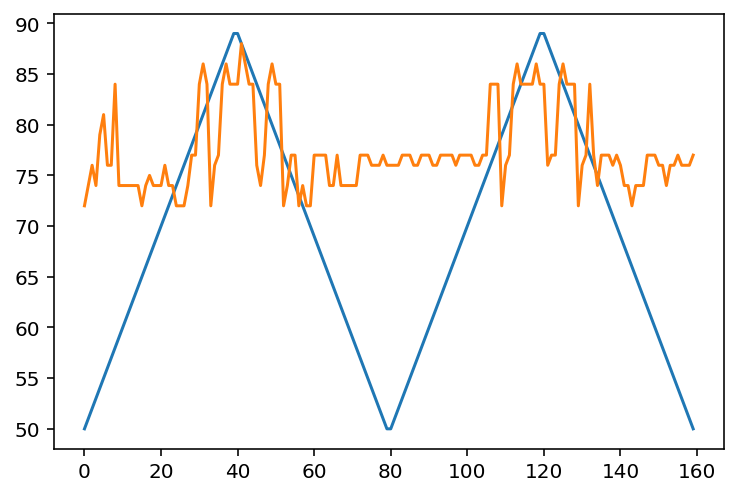

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [ ]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

In [ ]:
a = []
network_input=(network_input)
for b in range(len(network_input)):
    for k in range(len(network_input[b])):
        a.extend(network_input[b][k])
#a.extend(x for x in network_input)

In [ ]:

from collections import Counter
c = Counter(a)
c

In [ ]:
plt.plot(a*(89-50)+50)

In [ ]:
a=[(i*(89-50)+50) for i in a ]

In [ ]:
import math
a=[math.floor(i) for i in a]
a

In [ ]:
c = Counter(a)
c

In [ ]:
network_output=network_output.cpu().numpy().tolist()

In [ ]:
network_output

In [ ]:
c = Counter(network_output)
c